# inference_dev
notebook for developing inference pipeline with wtf setup

In [1]:
import numpy as np
import jax
import jax.numpy as jnp

import tinygp
from tinygp import GaussianProcess
from tinygp import kernels

import json
import pickle
import pandas as pd
from functools import partial

import ultranest

from scripts import numpy_compile, jax_compile, prior_funcs

##plotting
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import corner

plt.style.use("Solarize_Light2")
plt.rcParams.update({"axes.edgecolor": "black"})
plt.rcParams.update({"text.color": "black"})
plt.rcParams.update({"axes.labelcolor": "black"})
plt.rcParams.update({"xtick.color": "black"})
plt.rcParams.update({"ytick.color": "black"})
plt.rcParams.update({"font.family": "monospace"})

In [2]:
with open('pitchfork/pitchfork.json', 'r') as fp:
    pitchfork_dict = json.load(fp)

pitchfork = numpy_compile(pitchfork_dict)

jpitchfork = jax_compile(pitchfork_dict)

with open('pitchfork/pitchfork_info.json', 'r') as fp:
    pitchfork_info = json.load(fp)

pitchfork_cov = np.loadtxt('pitchfork/pitchfork_covariance.txt')

In [3]:
def predict(x, emulator, n_min=6, n_max=40, jaxxed=False):
    if jaxxed:
        ## def constants
        L_sun = 3.828e+26
        R_sun = 6.957e+8
        SB_sigma = 5.670374419e-8

        log_inputs_mean = jnp.array(pitchfork_info["data_scaling"]["inp_mean"][0])
        
        log_inputs_std = jnp.array(pitchfork_info["data_scaling"]["inp_std"][0])

        log_outputs_mean = jnp.array(pitchfork_info["data_scaling"]["classical_out_mean"][0] + pitchfork_info["data_scaling"]["astero_out_mean"][0])
        
        log_outputs_std = jnp.array(pitchfork_info["data_scaling"]["classical_out_std"][0] + pitchfork_info["data_scaling"]["astero_out_std"][0])
        
        pca_comps = jnp.array(pitchfork_info['custom_objects']['inverse_pca']['pca_comps'])
        
        pca_mean = jnp.array(pitchfork_info['custom_objects']['inverse_pca']['pca_mean'])        
            
        log_inputs = jnp.log10(x)
        
        standardised_log_inputs = (log_inputs - log_inputs_mean)/log_inputs_std

        preds = jpitchfork.forward_pass(standardised_log_inputs)

        pca_preds = jnp.tensordot(preds[1], pca_comps, 1) + pca_mean
        
        standardised_log_outputs = jnp.concatenate((jnp.array(preds[0]), pca_preds), axis=1)

        log_outputs = (standardised_log_outputs*log_outputs_std) + log_outputs_mean

        outputs = 10**log_outputs

        outputs = outputs.at[:,2].set(log_outputs[:,2]) ##we want star_feh in dex

        teff = jnp.array(((outputs[:,1]*L_sun) / (4*jnp.pi*SB_sigma*((outputs[:,0]*R_sun)**2)))**0.25)
        
        outputs = outputs.at[:,0].set(teff)
        
        outputs = jnp.concatenate((outputs[:,:3], outputs[:,n_min-3:n_max-2]), axis=1)

        return outputs
        
    else:
        ## def constants
        L_sun = 3.828e+26
        R_sun = 6.957e+8
        SB_sigma = 5.670374419e-8
        
        log_inputs_mean = np.array(pitchfork_info["data_scaling"]["inp_mean"][0])
        
        log_inputs_std = np.array(pitchfork_info["data_scaling"]["inp_std"][0])

        log_outputs_mean = np.array(pitchfork_info["data_scaling"]["classical_out_mean"][0] + pitchfork_info["data_scaling"]["astero_out_mean"][0])
        
        log_outputs_std = np.array(pitchfork_info["data_scaling"]["classical_out_std"][0] + pitchfork_info["data_scaling"]["astero_out_std"][0])

        pca_comps = np.array(pitchfork_info['custom_objects']['inverse_pca']['pca_comps'])
        
        pca_mean = np.array(pitchfork_info['custom_objects']['inverse_pca']['pca_mean'])
            
        log_inputs = np.log10(x)
        
        standardised_log_inputs = (log_inputs - log_inputs_mean)/log_inputs_std

        preds = pitchfork.forward_pass(standardised_log_inputs)

        pca_preds = np.tensordot(preds[1], pca_comps, 1) + pca_mean
        
        standardised_log_outputs = np.concatenate((np.array(preds[0]), pca_preds), axis=1)

        log_outputs = (standardised_log_outputs*log_outputs_std) + log_outputs_mean

        outputs = 10**log_outputs

        outputs[:,2] = log_outputs[:,2] ##we want star_feh in dex

        teff = np.array(((outputs[:,1]*L_sun) / (4*np.pi*SB_sigma*((outputs[:,0]*R_sun)**2)))**0.25)
        
        outputs[:,0] = teff
        
        outputs = np.concatenate((np.array(outputs[:,:3]), np.array(outputs[:,n_min-3:n_max-2])), axis=1)

        return outputs
        

In [4]:
jpredict = jax.jit(predict, static_argnums=1, static_argnames =['n_min', 'n_max', 'jaxxed'])

jmillion_points = jnp.full((1000000,5), 0.5)
j_million_preds = jpredict(jmillion_points, jpitchfork, n_min=6, n_max=28, jaxxed=True)

In [5]:
#parameters for star, [value,unc], NaN for not found/published
#1 : Lyttle
#2 : Asplund 2020
#3 : 
#4 : 

star_name = 'Sun-as-the-Sun'

star_dict={}

star_dict['initial_mass']=[1, 0.001] #1
star_dict['initial_Zinit']= [0.0154, 0.002] #2
star_dict['initial_Yinit']= [0.2766, 0.01] #2
star_dict['initial_MLT']= [1.92, 0.09] #2
star_dict['star_age']=[4.6, 0.1] #1

star_dict['calc_effective_T']=[5777, 20] #1
star_dict['radius']=[1, 0.001] #1
star_dict['luminosity']=[1, 0.001] #1
star_dict['star_feh']=[0, 0.01] #1

#############
star_dict['nu_0_6']= [972.615, 0.002]
star_dict['nu_0_7']= [1117.993, 0.004]
star_dict['nu_0_8']= [1263.198, 0.005]
star_dict['nu_0_9']= [1407.472, 0.006]
star_dict['nu_0_10']= [1548.336, 0.007]
star_dict['nu_0_11']= [1686.594, 0.012]
star_dict['nu_0_12']= [1822.202, 0.012]
star_dict['nu_0_13']= [1957.452, 0.012]
star_dict['nu_0_14']= [2093.518, 0.013]
star_dict['nu_0_15']= [2228.749, 0.014]
star_dict['nu_0_16']= [2362.788, 0.016]
star_dict['nu_0_17']= [2496.180, 0.017]
star_dict['nu_0_18']= [2629.668, 0.015]
star_dict['nu_0_19']= [2764.142, 0.015]
star_dict['nu_0_20']= [2899.022, 0.013]
star_dict['nu_0_21']= [3033.754, 0.014]
star_dict['nu_0_22']= [3168.618, 0.017]
star_dict['nu_0_23']= [3303.520, 0.021]
star_dict['nu_0_24']= [3438.992, 0.030]
star_dict['nu_0_25']= [3574.893, 0.048]
star_dict['nu_0_26']= [3710.717, 0.088]
star_dict['nu_0_27']= [3846.993, 0.177]
star_dict['nu_0_28']= [3984.214, 0.323]

##############

star_dict['dnu'] = [135.1, 0.2] #1
star_dict['nu_max'] = [3141, 12]

with open(f'{star_name}.json', 'w') as fp:
    json.dump(star_dict, fp)

star_dict

{'initial_mass': [1, 0.001],
 'initial_Zinit': [0.0154, 0.002],
 'initial_Yinit': [0.2766, 0.01],
 'initial_MLT': [1.92, 0.09],
 'star_age': [4.6, 0.1],
 'calc_effective_T': [5777, 20],
 'radius': [1, 0.001],
 'luminosity': [1, 0.001],
 'star_feh': [0, 0.01],
 'nu_0_6': [972.615, 0.002],
 'nu_0_7': [1117.993, 0.004],
 'nu_0_8': [1263.198, 0.005],
 'nu_0_9': [1407.472, 0.006],
 'nu_0_10': [1548.336, 0.007],
 'nu_0_11': [1686.594, 0.012],
 'nu_0_12': [1822.202, 0.012],
 'nu_0_13': [1957.452, 0.012],
 'nu_0_14': [2093.518, 0.013],
 'nu_0_15': [2228.749, 0.014],
 'nu_0_16': [2362.788, 0.016],
 'nu_0_17': [2496.18, 0.017],
 'nu_0_18': [2629.668, 0.015],
 'nu_0_19': [2764.142, 0.015],
 'nu_0_20': [2899.022, 0.013],
 'nu_0_21': [3033.754, 0.014],
 'nu_0_22': [3168.618, 0.017],
 'nu_0_23': [3303.52, 0.021],
 'nu_0_24': [3438.992, 0.03],
 'nu_0_25': [3574.893, 0.048],
 'nu_0_26': [3710.717, 0.088],
 'nu_0_27': [3846.993, 0.177],
 'nu_0_28': [3984.214, 0.323],
 'dnu': [135.1, 0.2],
 'nu_max': [3

## define priors

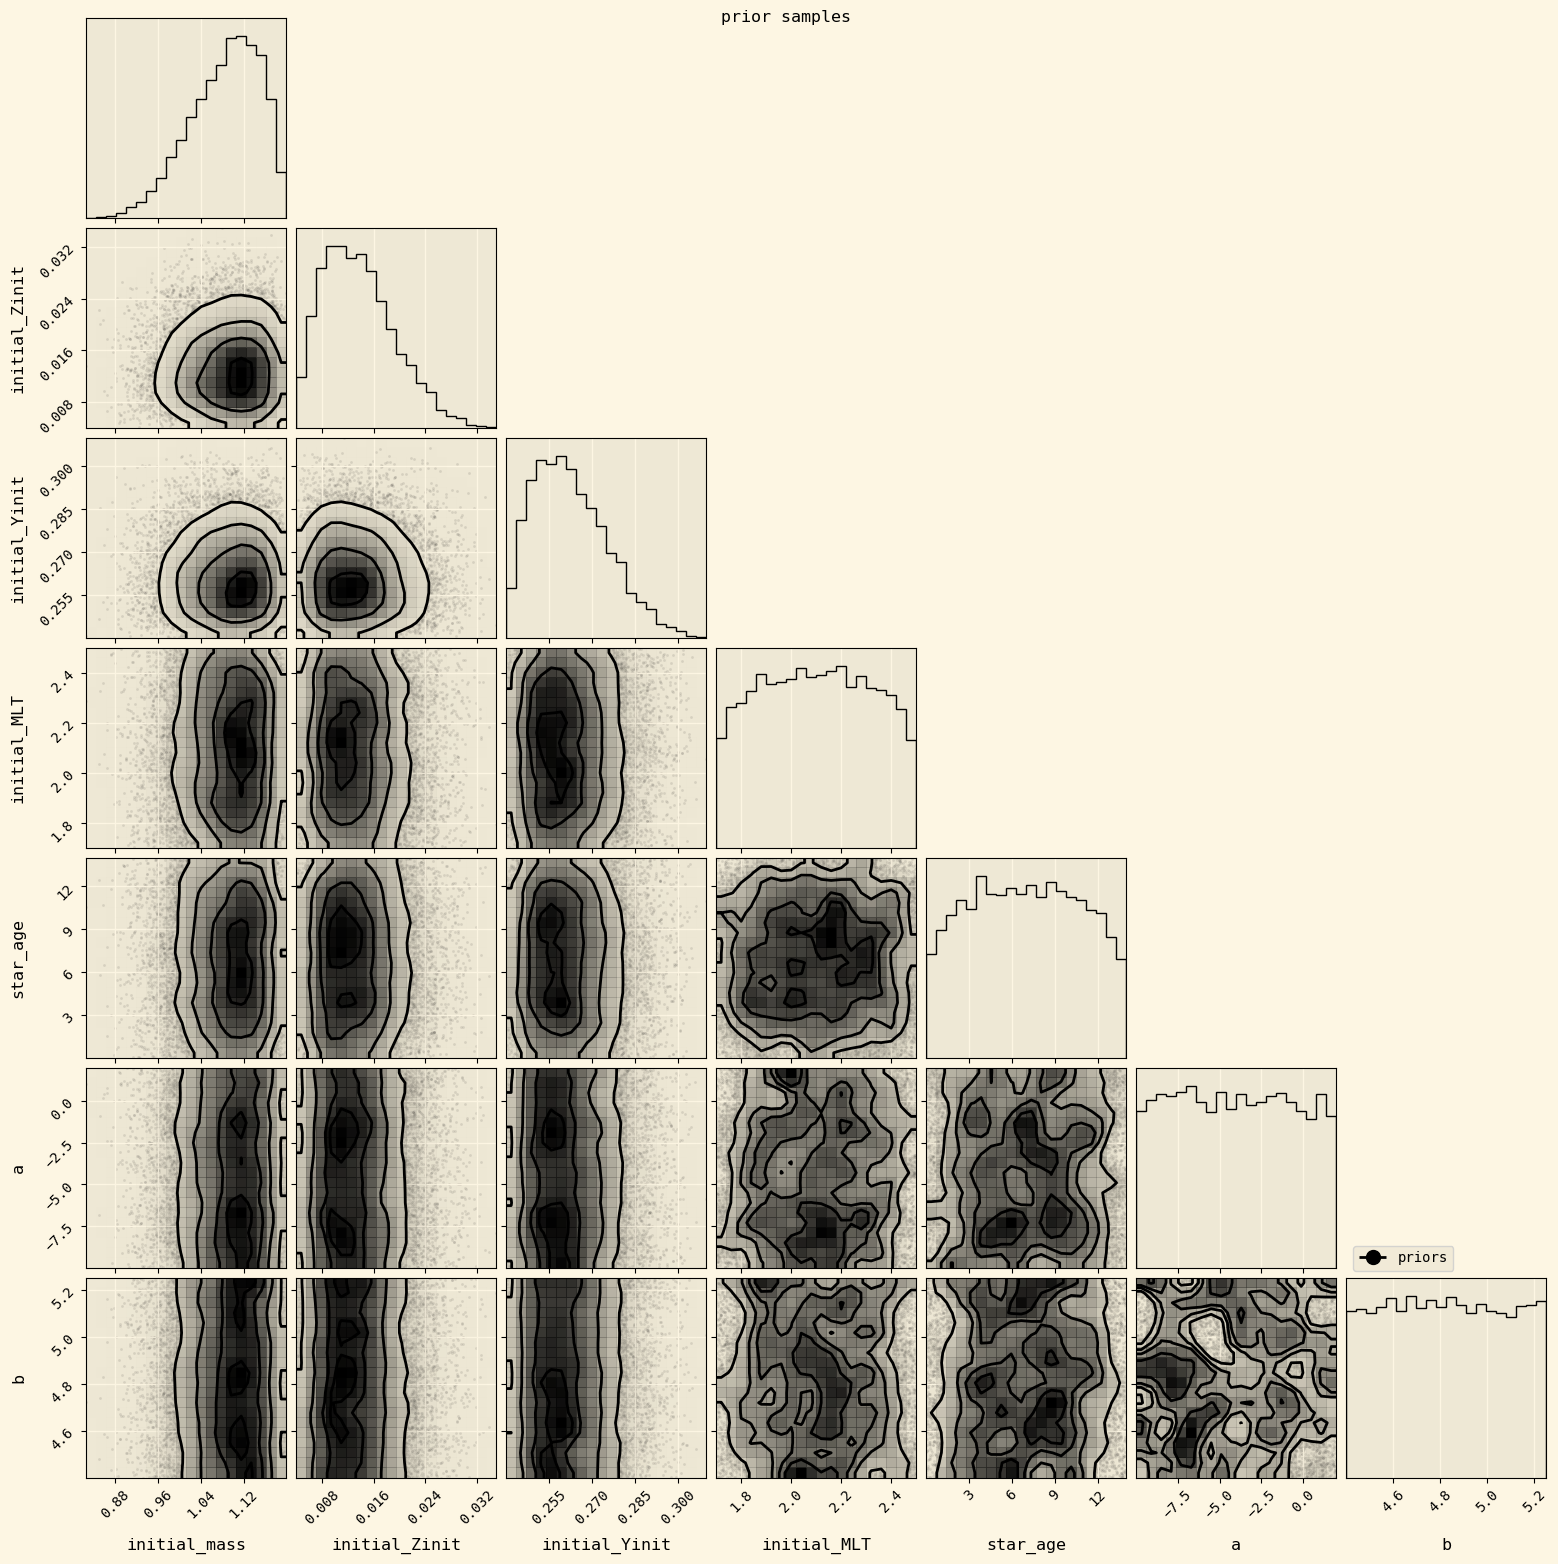

In [6]:
labels = ['initial_mass', 'initial_Zinit', 'initial_Yinit', 'initial_MLT', 'star_age', 'a', 'b']

mass_prior = prior_funcs.custom_beta_prior(0.8, 1.2, a=5, b=2)

Zinit_prior = prior_funcs.custom_beta_prior(0.004, 0.038, a=2, b=5)

Yinit_prior = prior_funcs.custom_beta_prior(0.24, 0.32, a=2, b=5)

MLT_prior = prior_funcs.custom_beta_prior(1.7, 2.5, a=1.2, b=1.2)

age_prior = prior_funcs.custom_beta_prior(0.03, 14, a=1.2, b=1.2)

a_prior = prior_funcs.custom_uniform_prior(-10, 2)

b_prior = prior_funcs.custom_uniform_prior(4.4, 5.25)

priors = [mass_prior, Zinit_prior, Yinit_prior, MLT_prior, age_prior, a_prior, b_prior]

size = 10000
plot_prior_samples = np.array([prior.rvs(size=size) for prior in priors])
legend_labels = []
corner_color = 'black'
corner.corner(plot_prior_samples.T, labels = labels, color=corner_color, hist_kwargs={'density':True}, smooth=True);
legend_labels = legend_labels + [Line2D([0], [0], marker='o', color =corner_color, markerfacecolor = corner_color, markersize=10, label='priors')]
plt.suptitle('prior samples')
plt.legend(handles=legend_labels, bbox_to_anchor=(0., 1.0, 1., .0), loc=0)
plt.show()

In [7]:
star_json = f'{star_name}.json'

star_df = pd.read_json(star_json).dropna(axis=1)

star_vals_df = star_df.iloc[[0]]

star_uncs_df = star_df.iloc[[1]]

star_obs_vals_df = star_vals_df.drop(['initial_mass', 'initial_Zinit', 'initial_Yinit', 'initial_MLT', 'star_age','radius', 'dnu', 'nu_max'], axis=1)

star_obs_uncs_df = star_uncs_df.drop(['initial_mass', 'initial_Zinit', 'initial_Yinit', 'initial_MLT', 'star_age','radius', 'dnu', 'nu_max'], axis=1)

nu_max = star_df["nu_max"].values[0]

### obs matrix
star_obs_vals_df = star_vals_df.drop(['initial_mass', 'initial_Zinit', 'initial_Yinit', 'initial_MLT', 'star_age','radius', 'dnu', 'nu_max'], axis=1)

star_obs_uncs_df = star_uncs_df.drop(['initial_mass', 'initial_Zinit', 'initial_Yinit', 'initial_MLT', 'star_age','radius', 'dnu', 'nu_max'], axis=1)

sigma_obs = (star_obs_uncs_df.values[0]*star_obs_uncs_df.values[0])*(np.identity(len(star_obs_uncs_df.values[0])))

### nn matrix
sigma_nn = pitchfork_cov

n_min = int(star_obs_vals_df.drop(['calc_effective_T', 'luminosity', 'star_feh'],axis=1).columns[0].replace('nu_0_',''))
n_max = int(star_obs_vals_df.drop(['calc_effective_T', 'luminosity', 'star_feh'],axis=1).columns[-1].replace('nu_0_',''))

sigma_nn_mask = np.zeros(len(sigma_nn), dtype=bool)
sigma_nn_mask[:3] = True
sigma_nn_mask[n_min-3:n_max-2] = True

sigma_nn_cropped = sigma_nn[:,sigma_nn_mask][sigma_nn_mask,:]

### gp matrix
obs_freqs = star_vals_df[[f"nu_0_{i}" for i in range(n_min, n_max+1)]].iloc[0].values.flatten()

dnu = star_df['dnu'].values[0]

kernel = 4*kernels.ExpSquared(scale=7*dnu)

gp = GaussianProcess(kernel, obs_freqs, diag=1e-12)

gp_cov = tinygp.solvers.DirectSolver.init(kernel, obs_freqs, noise=tinygp.noise.Dense(value=np.zeros((len(obs_freqs),len(obs_freqs))))).covariance()

gp_cov_padded = np.pad(gp_cov, (3,0))

# add covariance matrices
sigma = sigma_nn_cropped + sigma_obs + gp_cov_padded

sigma_inv = np.linalg.inv(sigma)

_, log_sigma_det = np.linalg.slogdet(sigma)

In [33]:
class nested_sampler():
    def __init__(self, priors, observed_vals, pitchfork, pitchfork_info, log_sigma_det, sigma_inv, nu_max, n_min=6, n_max=40, logl_scale = 1):
        self.priors = priors
        self.obs_val = observed_vals
        self.ndim = len(priors)
        self.pitchfork = pitchfork
        self.pitchfork_info = pitchfork_info
        self.logl_scale = logl_scale
        self.logl_factor = -(len(observed_vals)*0.5*np.log(2*np.pi))-(0.5*log_sigma_det)
        self.sigma_inv = sigma_inv
        self.n_min = n_min
        self.n_max = n_max
        self.nu_max = nu_max
        self.matmul_path = np.einsum_path('ij, jk, ik->i', np.array(observed_vals).reshape(-1,1), sigma_inv, np.array(observed_vals).reshape(-1,1), optimize='optimal')[0]
        
    def ptform(self, u):

        theta = np.array([self.priors[i].ppf(u[:,i]) for i in range(self.ndim)]).T
        return theta

    def surf_corr(self, freqs, a, b):
        return freqs + a*((freqs/self.nu_max)**b)

    def pitchfork_predict(self, x):
        ## def constants
        L_sun = 3.828e+26
        R_sun = 6.957e+8
        SB_sigma = 5.670374419e-8
        
        log_inputs_mean = np.array(self.pitchfork_info["data_scaling"]["inp_mean"][0])
        
        log_inputs_std = np.array(self.pitchfork_info["data_scaling"]["inp_std"][0])

        log_outputs_mean = np.array(self.pitchfork_info["data_scaling"]["classical_out_mean"][0] + self.pitchfork_info["data_scaling"]["astero_out_mean"][0])
        
        log_outputs_std = np.array(self.pitchfork_info["data_scaling"]["classical_out_std"][0] + self.pitchfork_info["data_scaling"]["astero_out_std"][0])

        pca_comps = np.array(self.pitchfork_info['custom_objects']['inverse_pca']['pca_comps'])
        
        pca_mean = np.array(self.pitchfork_info['custom_objects']['inverse_pca']['pca_mean'])
            
        log_inputs = np.log10(x)
        
        standardised_log_inputs = (log_inputs - log_inputs_mean)/log_inputs_std

        preds = self.pitchfork.forward_pass(standardised_log_inputs)

        pca_preds = np.tensordot(preds[1], pca_comps, 1) + pca_mean
        
        standardised_log_outputs = np.concatenate((np.array(preds[0]), pca_preds), axis=1)

        log_outputs = (standardised_log_outputs*log_outputs_std) + log_outputs_mean

        outputs = 10**log_outputs

        outputs[:,2] = log_outputs[:,2] ##we want star_feh in dex

        teff = np.array(((outputs[:,1]*L_sun) / (4*np.pi*SB_sigma*((outputs[:,0]*R_sun)**2)))**0.25)
        
        outputs[:,0] = teff
        
        outputs = np.concatenate((np.array(outputs[:,:3]), np.array(outputs[:,self.n_min-3:self.n_max-2])), axis=1)

        return outputs
    
    def logl(self, theta):

        m = self.pitchfork_predict(theta[:,:-2])

        a_arr = np.expand_dims(theta[:,-2],1)

        b_arr = np.expand_dims(theta[:,-1],1)

        m_corrected = m.copy()
        
        m_corrected[:,3:] = self.surf_corr(m[:,3:],a_arr, b_arr)
        
        residual_matrix = np.array(m_corrected-self.obs_val)

        ll = self.logl_factor-0.5*np.einsum('ij, jk, ik->i', residual_matrix, self.sigma_inv, residual_matrix, optimize=self.matmul_path)

        return self.logl_scale * ll

    def __call__(self, ndraw_min, ndraw_max, draw_multiple=True):

        self.sampler = ultranest.ReactiveNestedSampler(['initial_mass', 'initial_Zinit', 'initial_Yinit', 'initial_MLT', 'star_age','a','b'], self.logl, transform = self.ptform, vectorized=True, ndraw_min=ndraw_min, ndraw_max=ndraw_max, draw_multiple=draw_multiple)
        
        return self.sampler



In [34]:
%%time
ndraw_min=2**15
ndraw_max=2**15
min_num_live_points = 400

print(star_df[['initial_mass', 'initial_Zinit', 'initial_Yinit', 'initial_MLT', 'star_age']].iloc[[0]].to_markdown(index=False))
sampler = nested_sampler(priors=priors, observed_vals=star_obs_vals_df.values[0], pitchfork=pitchfork, pitchfork_info = pitchfork_info, log_sigma_det=log_sigma_det, sigma_inv=sigma_inv, nu_max = nu_max, n_min=n_min, n_max=n_max, logl_scale=1)
results = sampler(ndraw_min, ndraw_max).run(min_num_live_points=min_num_live_points, cluster_num_live_points=.1*min_num_live_points, frac_remain=.001)#, max_ncalls=5e6)

|   initial_mass |   initial_Zinit |   initial_Yinit |   initial_MLT |   star_age |
|---------------:|----------------:|----------------:|--------------:|-----------:|
|              1 |          0.0154 |          0.2766 |          1.92 |        4.6 |
[ultranest] Sampling 400 live points from prior ...


/home/oxs235/repos/ojscutt/pitchfork/scripts/wtf_compile.py:59: RuntimeWarning: overflow encountered in exp
  return self.np.where(x >= 0, x, self.np.exp(x)-1)


CPU times: user 1min 54s, sys: 238 ms, total: 1min 55s9] | it/evals=3240/76115 eff=4.2792% N=400       0      0  
Wall time: 4.46 s


KeyboardInterrupt: 

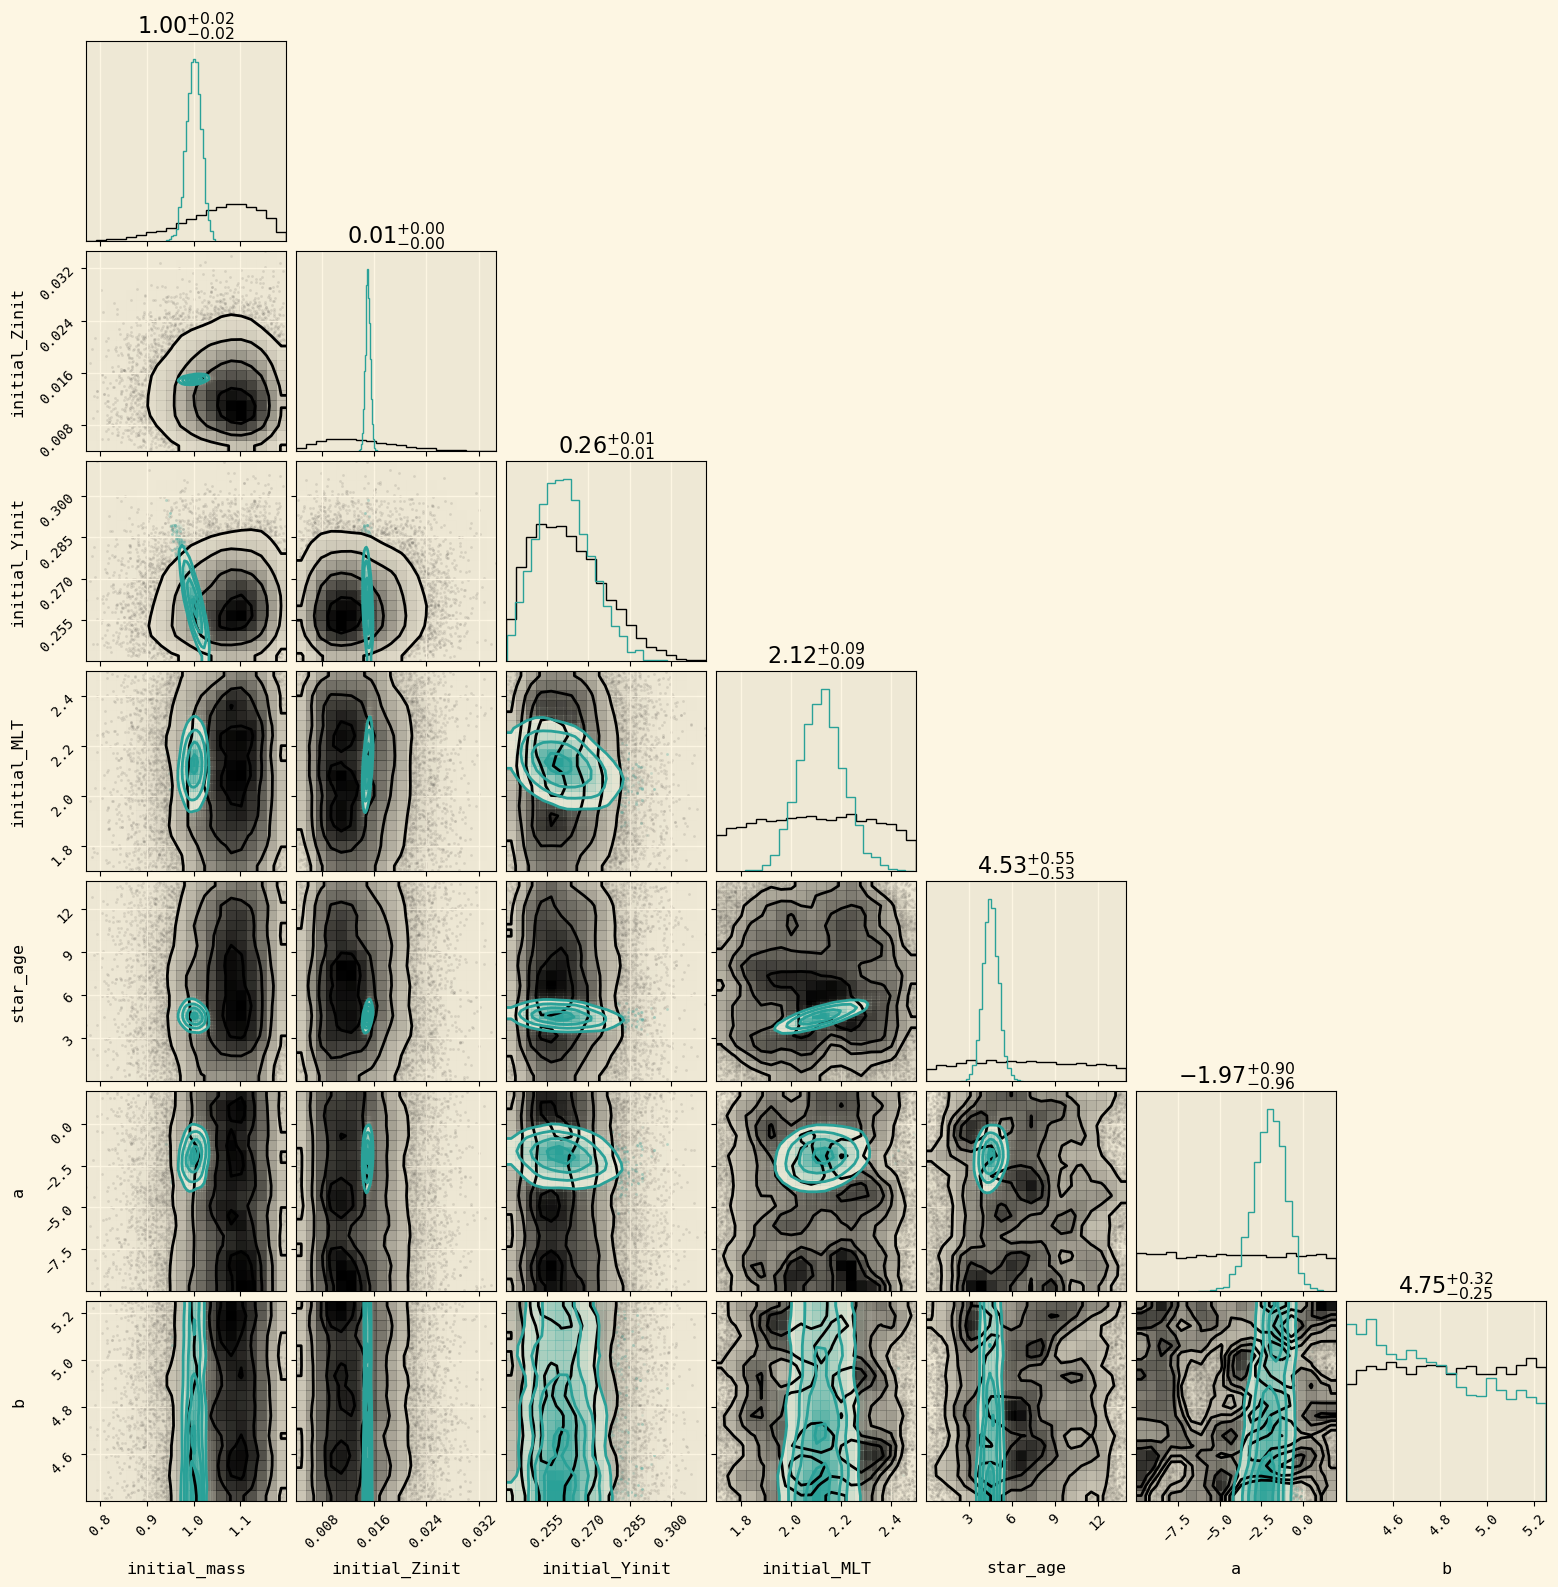

In [22]:
def inspect_star(samples):

    labels = ['initial_mass', 'initial_Zinit', 'initial_Yinit', 'initial_MLT', 'star_age', 'a', 'b']
    
    mass_prior = prior_funcs.custom_beta_prior(0.7, 1.2, a=5, b=2)
    
    Zinit_prior = prior_funcs.custom_beta_prior(0.004, 0.038, a=2, b=5)
    
    Yinit_prior = prior_funcs.custom_beta_prior(0.24, 0.32, a=2, b=5)
    
    MLT_prior = prior_funcs.custom_beta_prior(1.7, 2.5, a=1.2, b=1.2)
    
    age_prior = prior_funcs.custom_beta_prior(0.03, 14, a=1.2, b=1.2)
    
    a_prior = prior_funcs.custom_uniform_prior(-10, 2)
    
    b_prior = prior_funcs.custom_uniform_prior(4.4, 5.25)
    
    
    priors = [mass_prior, Zinit_prior, Yinit_prior, MLT_prior, age_prior, a_prior, b_prior]

    colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
    
    size = 10000
    prior_samples = np.array([prior.rvs(size=size) for prior in priors])
    legend_labels = []
    corner_color = 'black'
    figure = corner.corner(prior_samples.T, labels = labels, color=corner_color, hist_kwargs={'density':True}, smooth=True);
    

    star_json = f'{star_name}.json'
    
    star_df = pd.read_json(star_json).dropna(axis=1)

    published_inps = np.concatenate((star_df[['initial_mass', 'initial_Zinit', 'initial_Yinit', 'initial_MLT', 'star_age']].values[0],(np.nan,np.nan)))


    corner.corner(samples['samples'], fig=figure, color=colors[1], hist_kwargs={'density':True}, smooth=True,show_titles=True);

    plt.show()

    
inspect_star(results)

# and now jaxxed!

In [7]:
star_json = f'{star_name}.json'

star_df = pd.read_json(star_json).dropna(axis=1)

star_vals_df = star_df.iloc[[0]]

star_uncs_df = star_df.iloc[[1]]

star_obs_vals_df = star_vals_df.drop(['initial_mass', 'initial_Zinit', 'initial_Yinit', 'initial_MLT', 'star_age','radius', 'dnu', 'nu_max'], axis=1)

star_obs_uncs_df = star_uncs_df.drop(['initial_mass', 'initial_Zinit', 'initial_Yinit', 'initial_MLT', 'star_age','radius', 'dnu', 'nu_max'], axis=1)

nu_max = star_df["nu_max"].values[0]

### obs matrix
star_obs_vals_df = star_vals_df.drop(['initial_mass', 'initial_Zinit', 'initial_Yinit', 'initial_MLT', 'star_age','radius', 'dnu', 'nu_max'], axis=1)

star_obs_uncs_df = star_uncs_df.drop(['initial_mass', 'initial_Zinit', 'initial_Yinit', 'initial_MLT', 'star_age','radius', 'dnu', 'nu_max'], axis=1)

sigma_obs = (star_obs_uncs_df.values[0]*star_obs_uncs_df.values[0])*(np.identity(len(star_obs_uncs_df.values[0])))

### nn matrix
sigma_nn = pitchfork_cov

n_min = int(star_obs_vals_df.drop(['calc_effective_T', 'luminosity', 'star_feh'],axis=1).columns[0].replace('nu_0_',''))
n_max = int(star_obs_vals_df.drop(['calc_effective_T', 'luminosity', 'star_feh'],axis=1).columns[-1].replace('nu_0_',''))

sigma_nn_mask = np.zeros(len(sigma_nn), dtype=bool)
sigma_nn_mask[:3] = True
sigma_nn_mask[n_min-3:n_max-2] = True

sigma_nn_cropped = sigma_nn[:,sigma_nn_mask][sigma_nn_mask,:]

### gp matrix
obs_freqs = star_vals_df[[f"nu_0_{i}" for i in range(n_min, n_max+1)]].iloc[0].values.flatten()

dnu = star_df['dnu'].values[0]

kernel = 4*kernels.ExpSquared(scale=7*dnu)

gp = GaussianProcess(kernel, obs_freqs, diag=1e-12)

gp_cov = tinygp.solvers.DirectSolver.init(kernel, obs_freqs, noise=tinygp.noise.Dense(value=np.zeros((len(obs_freqs),len(obs_freqs))))).covariance()

gp_cov_padded = np.pad(gp_cov, (3,0))

# add covariance matrices
sigma = sigma_nn_cropped + sigma_obs + gp_cov_padded

sigma_inv = np.linalg.inv(sigma)

_, log_sigma_det = np.linalg.slogdet(sigma)

In [40]:
class jnested_sampler():
    def __init__(self, priors, observed_vals, jpitchfork, pitchfork_info, log_sigma_det, sigma_inv, nu_max, n_min=6, n_max=40, logl_scale = 1):
        self.priors = priors
        self.obs_val = observed_vals
        self.ndim = len(priors)
        self.jpitchfork = jpitchfork
        
        self.logl_scale = logl_scale
        self.logl_factor = -(len(observed_vals)*0.5*jnp.log(2*jnp.pi))-(0.5*log_sigma_det)
        self.sigma_inv = sigma_inv
        self.n_min = n_min
        self.n_max = n_max
        self.nu_max = nu_max
        self.matmul_path = jnp.einsum_path('ij, jk, ik->i', jnp.array(observed_vals).reshape(-1,1), sigma_inv, jnp.array(observed_vals).reshape(-1,1), optimize='optimal')[0]
        
        self.log_inputs_mean = jnp.array(pitchfork_info["data_scaling"]["inp_mean"][0])
        self.log_inputs_std = jnp.array(pitchfork_info["data_scaling"]["inp_std"][0])
        self.log_outputs_mean = jnp.array(pitchfork_info["data_scaling"]["classical_out_mean"][0] + pitchfork_info["data_scaling"]["astero_out_mean"][0])
        self.log_outputs_std = jnp.array(pitchfork_info["data_scaling"]["classical_out_std"][0] + pitchfork_info["data_scaling"]["astero_out_std"][0])
        self.pca_comps = jnp.array(pitchfork_info['custom_objects']['inverse_pca']['pca_comps'])
        self.pca_mean = jnp.array(pitchfork_info['custom_objects']['inverse_pca']['pca_mean']) 

        self.L_sun = 3.828e+26
        self.R_sun = 6.957e+8
        self.SB_sigma = 5.670374419e-8  
        
    def ptform(self, u):

        theta = np.array([self.priors[i].ppf(u[:,i]) for i in range(self.ndim)]).T
        return theta

    def surf_corr(self, freqs, a, b):
        return freqs + a*((freqs/self.nu_max)**b)

    def pitchfork_predict(self, x):
        
        log_inputs = jnp.log10(x)
        
        standardised_log_inputs = (log_inputs - self.log_inputs_mean)/self.log_inputs_std

        preds = jpitchfork.forward(standardised_log_inputs)

        pca_preds = jnp.tensordot(preds[1], self.pca_comps, 1) + self.pca_mean
        
        standardised_log_outputs = jnp.concatenate((jnp.array(preds[0]), pca_preds), axis=1)

        log_outputs = (standardised_log_outputs*self.log_outputs_std) + self.log_outputs_mean

        outputs = 10**log_outputs

        outputs = outputs.at[:,2].set(log_outputs[:,2]) ##we want star_feh in dex

        teff = jnp.array(((outputs[:,1]*self.L_sun) / (4*jnp.pi*self.SB_sigma*((outputs[:,0]*self.R_sun)**2)))**0.25)
        
        outputs = outputs.at[:,0].set(teff)
        
        outputs = jnp.concatenate((outputs[:,:3], outputs[:,self.n_min-3:self.n_max-2]), axis=1)

        return outputs
    
    def logl(self, theta):
        theta = jnp.array(theta)
        
        m = self.pitchfork_predict(theta[:,:-2])

        a_arr = jnp.expand_dims(theta[:,-2],1)

        b_arr = jnp.expand_dims(theta[:,-1],1)

        m_corrected = m.at[:,3:].set(self.surf_corr(m[:,3:],a_arr, b_arr))
        
        residual_matrix = jnp.array(m_corrected-self.obs_val)

        ll = self.logl_factor-0.5*jnp.einsum('ij, jk, ik->i', residual_matrix, self.sigma_inv, residual_matrix, optimize=self.matmul_path)

        return self.logl_scale * np.array(ll)

    def __call__(self, ndraw_min, ndraw_max, draw_multiple=True):

        self.sampler = ultranest.ReactiveNestedSampler(['initial_mass', 'initial_Zinit', 'initial_Yinit', 'initial_MLT', 'star_age','a','b'], self.logl, transform = self.ptform, vectorized=True, ndraw_min=ndraw_min, ndraw_max=ndraw_max, draw_multiple=draw_multiple)
        
        return self.sampler



In [41]:
%%time
ndraw_min=2**14
ndraw_max=2**14
min_num_live_points = 400

print(star_df[['initial_mass', 'initial_Zinit', 'initial_Yinit', 'initial_MLT', 'star_age']].iloc[[0]].to_markdown(index=False))
sampler = jnested_sampler(priors=priors, observed_vals=jnp.array(star_obs_vals_df.values[0]), jpitchfork=jpitchfork, pitchfork_info = pitchfork_info, log_sigma_det=jnp.array(log_sigma_det), sigma_inv=jnp.array(sigma_inv), nu_max = nu_max, n_min=n_min, n_max=n_max, logl_scale=1)
results = sampler(ndraw_min, ndraw_max).run(min_num_live_points=min_num_live_points, cluster_num_live_points=.1*min_num_live_points, frac_remain=.01)#, max_ncalls=5e6)

|   initial_mass |   initial_Zinit |   initial_Yinit |   initial_MLT |   star_age |
|---------------:|----------------:|----------------:|--------------:|-----------:|
|              1 |          0.0154 |          0.2766 |          1.92 |        4.6 |
[ultranest] Sampling 400 live points from prior ...


CPU times: user 1min 28s, sys: 5.4 s, total: 1min 34s86] | it/evals=2855/48006 eff=5.9971% N=400       0       0 
Wall time: 1min 49s


KeyboardInterrupt: 

# now with jitters!

In [ ]:
class jnested_sampler():
    def __init__(self, priors, observed_vals, jpitchfork, pitchfork_info, log_sigma_det, sigma_inv, nu_max, n_min=6, n_max=40, logl_scale = 1):
        self.priors = priors
        self.obs_val = observed_vals
        self.ndim = len(priors)
        self.jpitchfork = jpitchfork
        self.pitchfork_info = pitchfork_info
        self.logl_scale = logl_scale
        self.logl_factor = -(len(observed_vals)*0.5*np.log(2*np.pi))-(0.5*log_sigma_det)
        self.sigma_inv = sigma_inv
        self.n_min = n_min
        self.n_max = n_max
        self.nu_max = nu_max
        self.matmul_path = np.einsum_path('ij, jk, ik->i', np.array(observed_vals).reshape(-1,1), sigma_inv, np.array(observed_vals).reshape(-1,1), optimize='optimal')[0]
        
    def ptform(self, u):

        theta = np.array([self.priors[i].ppf(u[:,i]) for i in range(self.ndim)]).T
        return theta

    def surf_corr(self, freqs, a, b):
        return freqs + a*((freqs/self.nu_max)**b)

    def pitchfork_predict(self, x):
        ## def constants
        L_sun = 3.828e+26
        R_sun = 6.957e+8
        SB_sigma = 5.670374419e-8
        
        log_inputs_mean = np.array(self.pitchfork_info["data_scaling"]["inp_mean"][0])
        
        log_inputs_std = np.array(self.pitchfork_info["data_scaling"]["inp_std"][0])

        log_outputs_mean = np.array(self.pitchfork_info["data_scaling"]["classical_out_mean"][0] + self.pitchfork_info["data_scaling"]["astero_out_mean"][0])
        
        log_outputs_std = np.array(self.pitchfork_info["data_scaling"]["classical_out_std"][0] + self.pitchfork_info["data_scaling"]["astero_out_std"][0])

        pca_comps = np.array(self.pitchfork_info['custom_objects']['inverse_pca']['pca_comps'])
        
        pca_mean = np.array(self.pitchfork_info['custom_objects']['inverse_pca']['pca_mean'])
            
        log_inputs = np.log10(x)
        
        standardised_log_inputs = (log_inputs - log_inputs_mean)/log_inputs_std

        x_batch_size = x.shape[0]

        preds = self.jpitchfork.forward_pass(standardised_log_inputs)

        pca_preds = np.tensordot(preds[1], pca_comps, 1) + pca_mean
        
        standardised_log_outputs = np.concatenate((np.array(preds[0]), pca_preds), axis=1)

        log_outputs = (standardised_log_outputs*log_outputs_std) + log_outputs_mean

        outputs = 10**log_outputs

        outputs[:,2] = log_outputs[:,2] ##we want star_feh in dex

        teff = np.array(((outputs[:,1]*L_sun) / (4*np.pi*SB_sigma*((outputs[:,0]*R_sun)**2)))**0.25)
        
        outputs[:,0] = teff
        
        outputs = np.concatenate((np.array(outputs[:,:3]), np.array(outputs[:,self.n_min-3:self.n_max-2])), axis=1)

        return outputs
    
    def logl(self, theta):

        m = self.pitchfork_predict(theta[:,:-2])

        a_arr = np.expand_dims(theta[:,-2],1)

        b_arr = np.expand_dims(theta[:,-1],1)

        m_corrected = m.copy()
        
        m_corrected[:,3:] = self.surf_corr(m[:,3:],a_arr, b_arr)
        
        residual_matrix = np.array(m_corrected-self.obs_val)

        ll = self.logl_factor-0.5*np.einsum('ij, jk, ik->i', residual_matrix, self.sigma_inv, residual_matrix, optimize=self.matmul_path)

        return self.logl_scale * ll

    def __call__(self, ndraw_min, ndraw_max, draw_multiple=True):

        self.sampler = ultranest.ReactiveNestedSampler(['initial_mass', 'initial_Zinit', 'initial_Yinit', 'initial_MLT', 'star_age','a','b'], self.logl, transform = self.ptform, vectorized=True, ndraw_min=ndraw_min, ndraw_max=ndraw_max, draw_multiple=draw_multiple)
        
        return self.sampler



In [18]:
%%time
ndraw_min=2**15
ndraw_max=2**15
min_num_live_points = 400

print(star_df[['initial_mass', 'initial_Zinit', 'initial_Yinit', 'initial_MLT', 'star_age']].iloc[[0]].to_markdown(index=False))
sampler = jnested_sampler(priors=priors, observed_vals=jnp.array(star_obs_vals_df.values[0]), jpitchfork=jpitchfork, pitchfork_info = pitchfork_info, log_sigma_det=jnp.array(log_sigma_det), sigma_inv=jnp.array(sigma_inv), nu_max = nu_max, n_min=n_min, n_max=n_max, logl_scale=1)
results = sampler(ndraw_min, ndraw_max).run(min_num_live_points=min_num_live_points, cluster_num_live_points=.1*min_num_live_points, frac_remain=.01)#, max_ncalls=5e6)

|   initial_mass |   initial_Zinit |   initial_Yinit |   initial_MLT |   star_age |
|---------------:|----------------:|----------------:|--------------:|-----------:|
|              1 |          0.0154 |          0.2766 |          1.92 |        4.6 |
CPU times: user 14.9 ms, sys: 15.6 ms, total: 30.5 ms
Wall time: 25.6 ms


TypeError: list indices must be integers or slices, not tuple